# Test di Benford

Classifica anomalie nei dati regionali.

> Max Pierini

In [1]:
import numpy as np
import pandas as pd
#from benfordslaw import benfordslaw
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import Markdown
import seaborn as sns

import scipy.stats as sps

sns.set()

In [2]:
def ks_test_two(sample1, sample2, alphas):
    """
    Kolmogorov-Smirnov test for two ordered samples.
    Tests the null hypothesis that given ordered samples
    come from populations with the same distribution
    with Kolmogorov-Smirnov test for two samples.
    
    Args:
        - sample1 (list): sample1 to be tested *
        - sample2 (list): sample2 to be tested *
        - alphas  (list): significance levels

        * can be list or one-dimensional numpy array
    
    Returns:
        Statisical and Critical values of K-S test,
        n of K-S two-sample distribution, level and
        significance, p-value of K-S test.
        
    References:
        Charles Zaiontz - Real Statistics 2020
        https://www.real-statistics.com/non-parametric-tests/
        goodness-of-fit-tests/two-sample-kolmogorov-smirnov-test/
    """

    
    # samples to numpy arrays
    sample1 = np.array(sample1)
    sample2 = np.array(sample2)
    
    # compute empirical cumulative density functions
    ecdf1 = (sample1 / sample1.sum()).cumsum()
    ecdf2 = (sample2 / sample2.sum()).cumsum()
    
    # take ECDF difference and D-stat
    ecdf_diff = abs(ecdf1 - ecdf2)
    D_stat = ecdf_diff.max()
    
    # define K-S distribution and take D-crit
    n = (sample1.sum() * sample2.sum()) / (sample1.sum() + sample2.sum())
    KS_dist = sps.kstwo(np.round(n))
    # p-value
    p_val = KS_dist.sf(D_stat)
    # D-crit is Inverse Survival Function value at alpha
    level = 0
    significance = ''
    D_crits = []
    for alpha in sorted(alphas, reverse=True):
        D_crit = KS_dist.isf(alpha)
        D_crits.append(D_crit)
        if D_stat > D_crit:
            significance += '*'
            level += 1
    
    # null hypothesis test
    #if D_stat > D_crit:
    #    print('Null hypothesis rejected')
    #else:
    #    print('Null hypothesis accepted')
    
    return D_stat, D_crits, n, level, significance, p_val

La legge di Benford afferma che, nella maggior parte delle raccolte di dati numerici reali e naturali senza costrizioni, la prima cifra (ad esempio, la cifra "1" nel numero "1976") è distribuita in forma logaritmica ([Benford, 1938](https://www.jstor.org/stable/984802))

$$
P(d) = \log_{10}\left(1 + \frac{1}{d}\right)
$$

dove $d \in [1...9]$ è la prima cifra e $P(d)$ è la probabilità di osservare la cifra $d$ nella raccolta di dati.

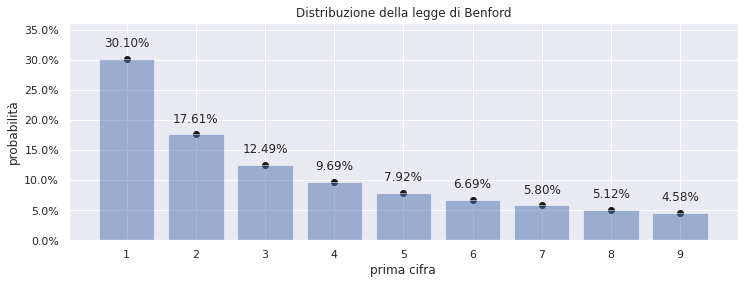

In [3]:
d = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
P = np.log10(1 + 1/d)
P /= P.sum()
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(d, P, alpha=.5)
ax.scatter(d, P, color='k')
for i, p in zip(d, P):
    ax.text(
        i, p+.02,
        f"{p:.2%}",
        ha='center'
    )
ax.set(
    xticks=d,
    xlabel='prima cifra',
    ylabel='probabilità',
    title='Distribuzione della legge di Benford',
    ylim=(0, np.max(P)*1.2)
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))

Nota la legge è possibile testare se una collezione di dati rispetta questa distribuzione con un test di ipotesi nulla, dove $H_0$ corrisponde all'ipotesi che i dati empirici osservati provengano dalla stessa distribuzione teorica di Benford. Questi test sono stati ampiamente utilizzati, ad esempio, per verificare anomalie in dati economici e politici ([Nye and Moul, 2007](https://doi.org/10.2202/1935-1690.1449), [Gonzales-Garcia and Pastor, 2009](https://www.imf.org/en/Publications/WP/Issues/2016/12/31/Benfords-Law-and-Macroeconomic-Data-Quality-22581), [Rauch et al., 2011](https://doi.org/10.1111/j.1468-0475.2011.00542.x), [Holz, 2014](http://dx.doi.org/10.1016/j.chieco.2014.06.009), [Nigrini 1996](https://search.proquest.com/openview/25e7a047460619eadea963d5e63ae375/1?pq-origsite=gscholar&cbl=31656)) e recentemente anche sui dati della pandemia di COVID-19 ([Koch and Okamura, 2020](https://dx.doi.org/10.1016%2Fj.econlet.2020.109573)).

Vengono solitamente usati due stimatori per la verifica dell'ipotesi nulla:

- $\chi^2$ (chi quadrato)
- K-S (Kolmogorov-Smirnov)

i cui $p$-value sono spesso combinati. Nel lavoro di Kock e Okamura, viene utilizzato Kuiper test, una versione modificata del K-S.

Laddove il $p$-value ottenuto dal test di ipotesi nulla sia inferiore ad un certo livello di significatività (solitamente si usano tre livelli di significatività crescente, 0.10, 0.05, e 0.01) esiste la possibilità che la distribuzione osservata non segua la legge di Benford ed è pertanto necessario indagare sulle cause che rendono i dati raccolti meno verosimilmente "naturali".

In questa analisi, si presenta una serie di test di Benford sui dati regionali della pandemia di COVID-19 nelle singole regioni italiane. Come nel paper di [Koch and Okamura, 2020](https://dx.doi.org/10.1016%2Fj.econlet.2020.109573) il test verrà effettuato sulla parte di dati in cui l'epidemia è in fase eponenziale in ciascuna delle due ondate del 2020 ma, analizzando qui i dati regionali separati, le due ondate saranno considerati nel loro insieme per estendere l'ampiezza dei campioni ed evitare sottostime.

> **NOTA BENE**: Vengono qui mostrati solamente i risultati dei test e il sommario dei livelli di significatività. Non si formula nessuna ipotesi sul motivo per cui si osservino anomalie in alcuni set di dati o in alcune regioni.

Essendo lo scopo di questa analisi non già ricercare anomalie specifiche ma classificare quali regioni e quali campi evidenzino maggiori probabilità di anomalie, sarà usato un test di Kolmogorov-Smirnov per due campioni di frequenze categoriche ordinate ([Pierini, 2020](https://epidata.it/PDF/H0_KS.pdf)) e saranno evidenziati quattro livelli $\lambda$ di significatività

- $\lambda=0$ per $p>0.10$ (verde) non significativo
- $\lambda=1$ per $p<0.10$ (giallo) bassa significatività
- $\lambda=2$ per $p<0.05$ (rosso) media significatività
- $\lambda=3$ per $p<0.01$ (viola) alta significatività

Infine per ogni regione e per ogni campo di dati sarà calcolato un livello di significatività percentuale $L$ delle anomalie

$$
L = \frac{ \sum_{i=1}^{N} \lambda_{i} }{ 3N }
$$

dove $N$ è il numero di regioni o di campi e $\lambda_{i}$ è il numero corrispondente al livello di significatività $\lambda$ dell'elemento $i$.

In [4]:
# %% Final counts and the frequencies in percentage.
def _count_first_digit(data):
    # Get only non-zero values
    data = data[data>1]
    # Get the first digits
    first_digits = list(map(lambda x: int(str(x)[0]), data))

    # Count occurences. Make sure every position is for [1-9]
    empirical_counts = np.zeros(9)
    digit = []
    for i in range(1, 10):
        empirical_counts[i - 1] = first_digits.count(i)
        digit.append(i)

    # Total amount
    total_count=sum(empirical_counts)
    # Make percentage
    empirical_percentage = np.array([(i / total_count) for i in empirical_counts])
    empirical_percentage /= empirical_percentage.sum()
    # Return
    return(empirical_counts, empirical_percentage, total_count, digit)

# Compute expected counts
def _get_expected_counts(P, total_count):
    """Return list of expected Benford's Law counts for total sample count."""
    out=[]
    for p in P:
        out.append(round(p * total_count))
    return(out)

In [5]:
def covid_regioni():
    df = pd.read_csv(
        "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
        parse_dates=['data'],
        index_col=['data'],
        squeeze=True).sort_index()
    df.index = df.index.normalize()
    return df

In [6]:
it = covid_regioni()

In [7]:
cols = [
    #'differenza_ricoverati', 'differenza_intensive',
    #'differenza_ospedalizzati', 'differenza_isolamenti',
    #'variazione_totale_positivi',
    'nuovi_positivi',
    'nuovi_tamponi', 
    'nuovi_casi_testati', 
    'nuovi_deceduti',
    'nuovi_guariti', 
    'nuovi_casi_da_sospetto_diagnostico',
    'nuovi_casi_da_screening',
    'totale_positivi',
    'isolamento_domiciliare',
    'totale_ospedalizzati',
    'ricoverati_con_sintomi',
    'terapia_intensiva'
]

In [8]:
#cols = it.columns[5:-1]

In [9]:
#cols.size

In [10]:
display(Markdown(f"""
Dati utilizzati:
{', '.join(cols)}.
"""))


Dati utilizzati:
nuovi_positivi, nuovi_tamponi, nuovi_casi_testati, nuovi_deceduti, nuovi_guariti, nuovi_casi_da_sospetto_diagnostico, nuovi_casi_da_screening, totale_positivi, isolamento_domiciliare, totale_ospedalizzati, ricoverati_con_sintomi, terapia_intensiva.


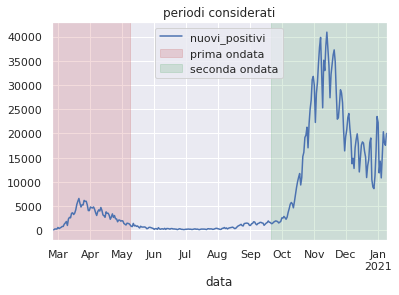

prima ondata: dal 2020-02-24 al 2020-05-09
seconda ondata: dal 2020-09-21 al 2021-01-09


In [11]:
wave_1_a = 0
wave_1_z = 30*2+15
wave_2_a = 30*7
wave_2_z = -1

ax = it.groupby('data').nuovi_positivi.sum().plot()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.fill_betweenx(
    [ylim[0], ylim[-1]],
    it.groupby('data').sum().index[wave_1_a],
    it.groupby('data').sum().index[wave_1_z],
    color='r', alpha=.2,
    label='prima ondata'
)
ax.fill_betweenx(
    [ylim[0], ylim[-1]],
    it.groupby('data').sum().index[wave_2_a],
    it.groupby('data').sum().index[wave_2_z],
    color='g', alpha=.2,
    label='seconda ondata'
)
ax.set(
    xlim=xlim,
    ylim=ylim,
    title='periodi considerati'
)
ax.legend(loc='upper center')
plt.show()

print(f"prima ondata: dal {it.groupby('data').sum().index[wave_1_a].date()} al {it.groupby('data').sum().index[wave_1_z].date()}")
print(f"seconda ondata: dal {it.groupby('data').sum().index[wave_2_a].date()} al {it.groupby('data').sum().index[wave_2_z].date()}")

# Risultati

## Abruzzo

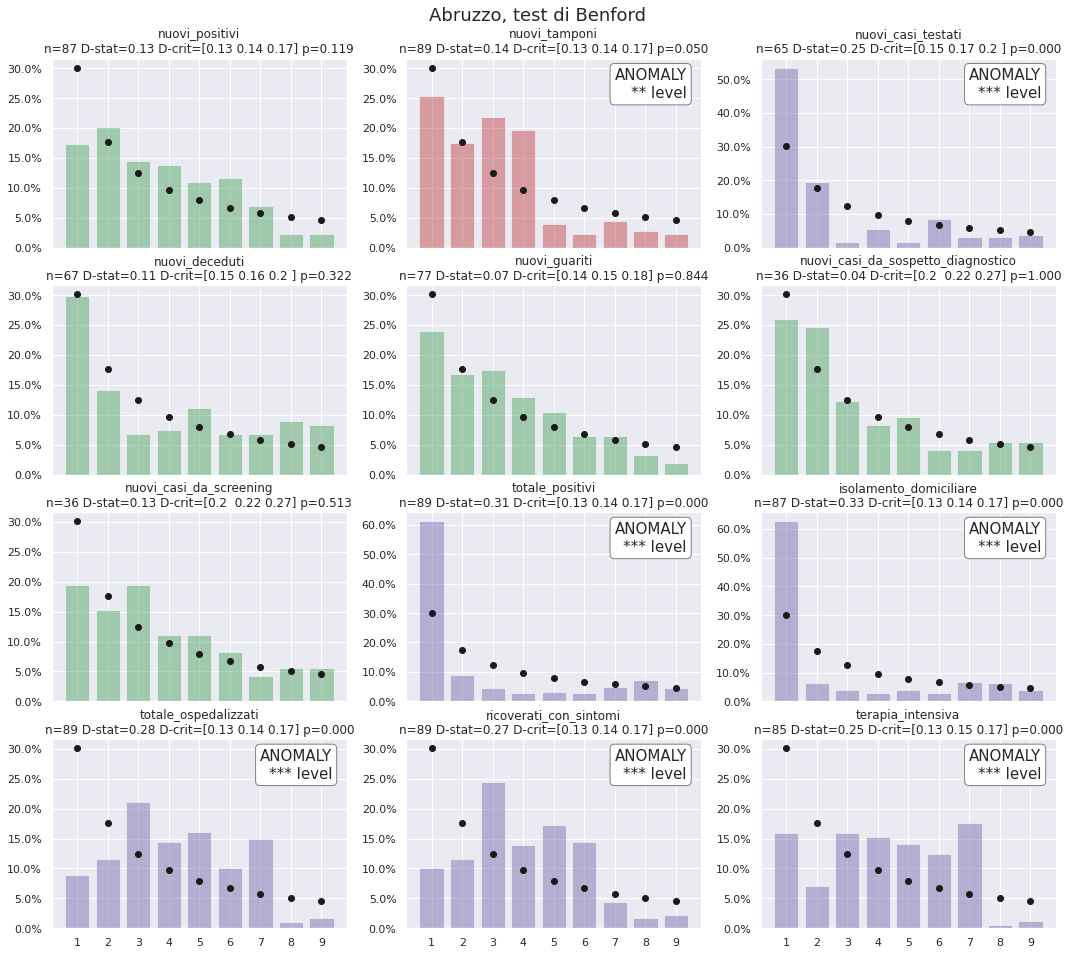

## Basilicata

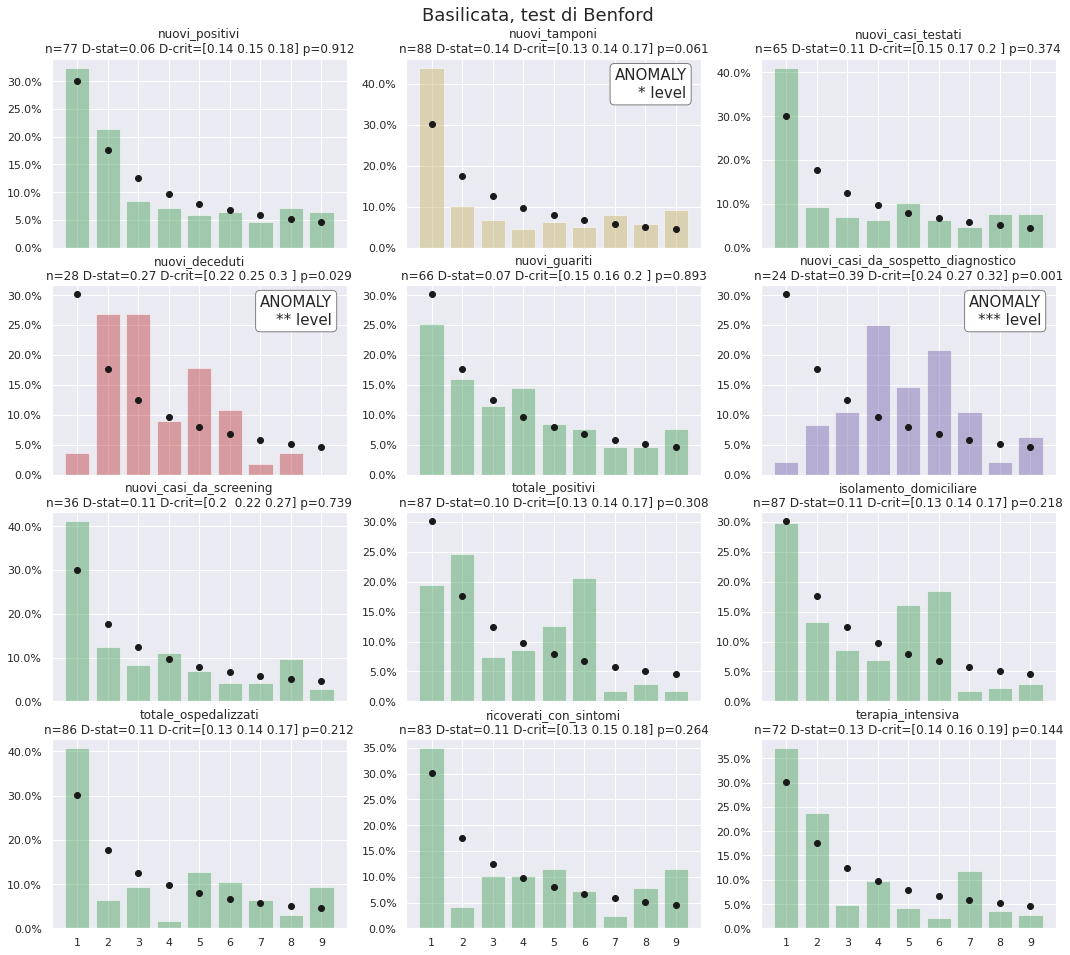

## Calabria

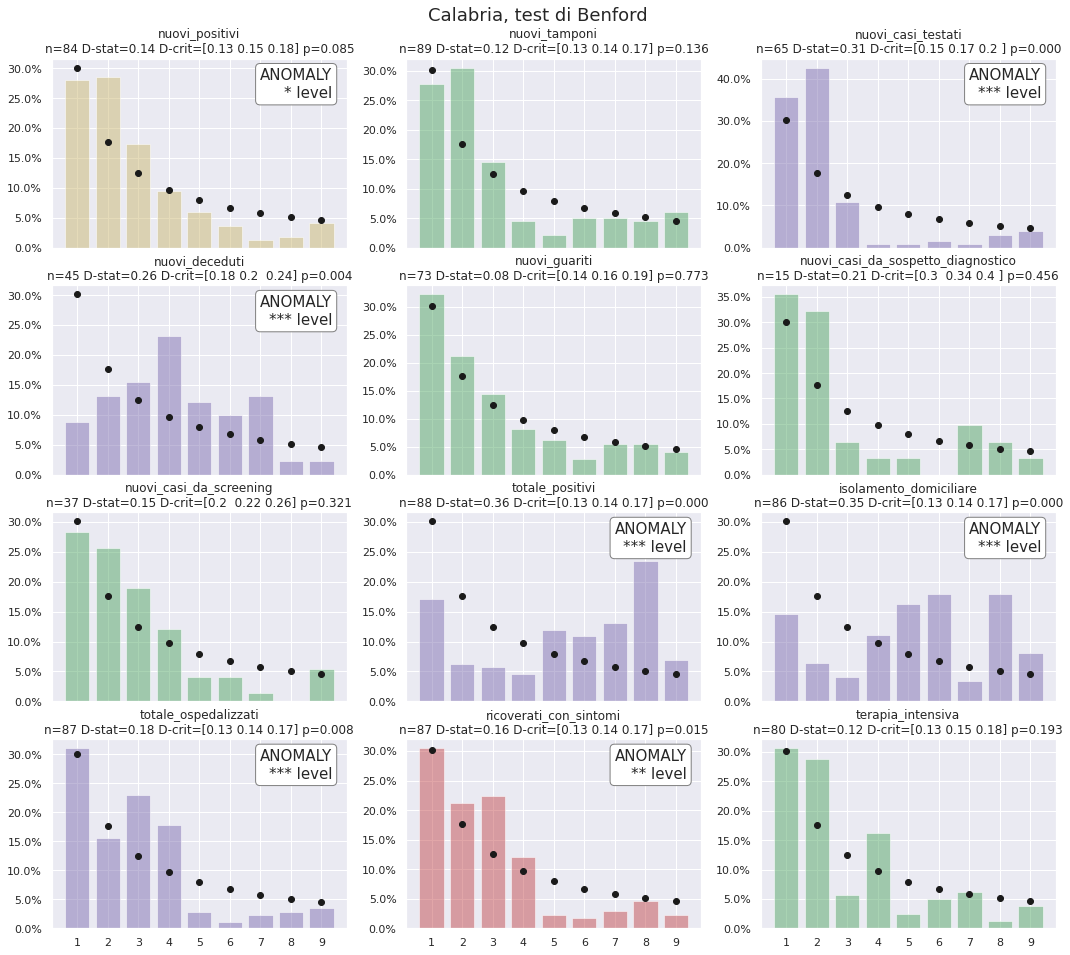

## Campania

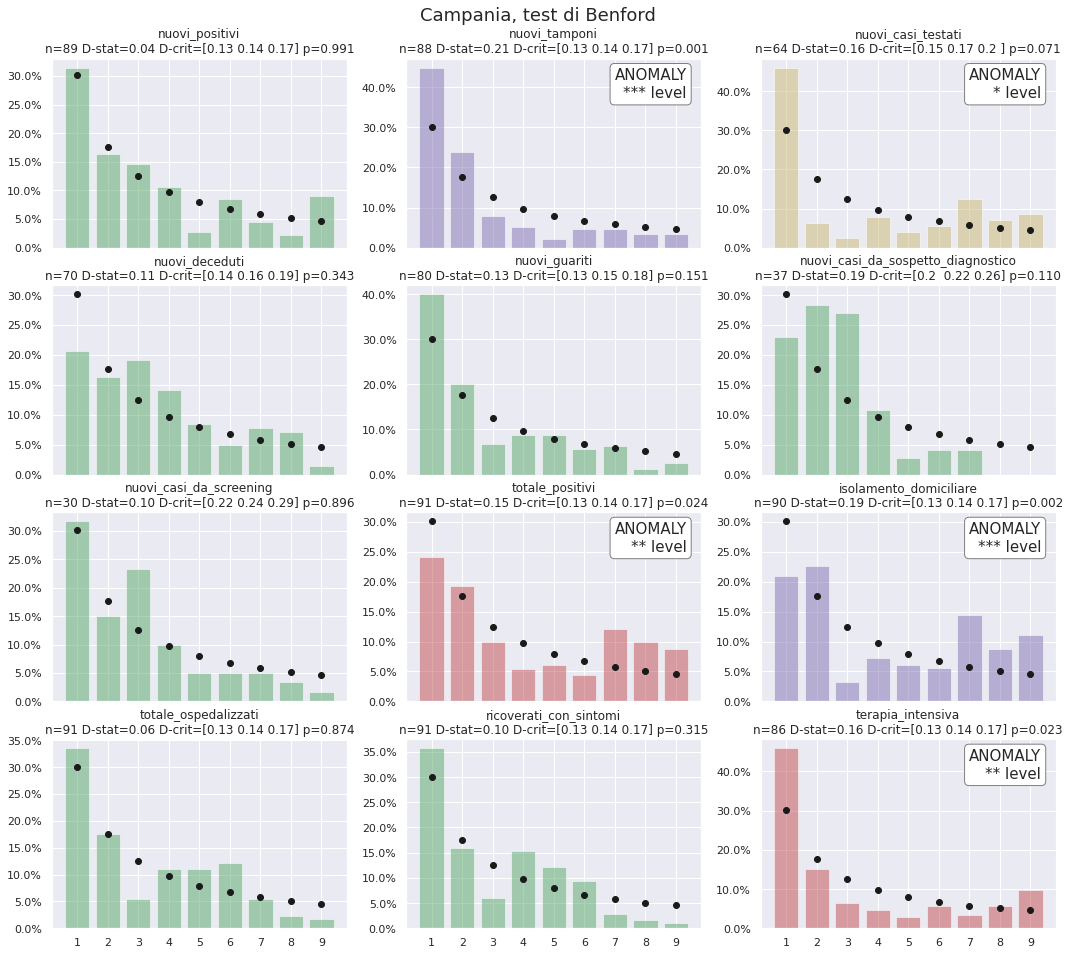

## Emilia-Romagna

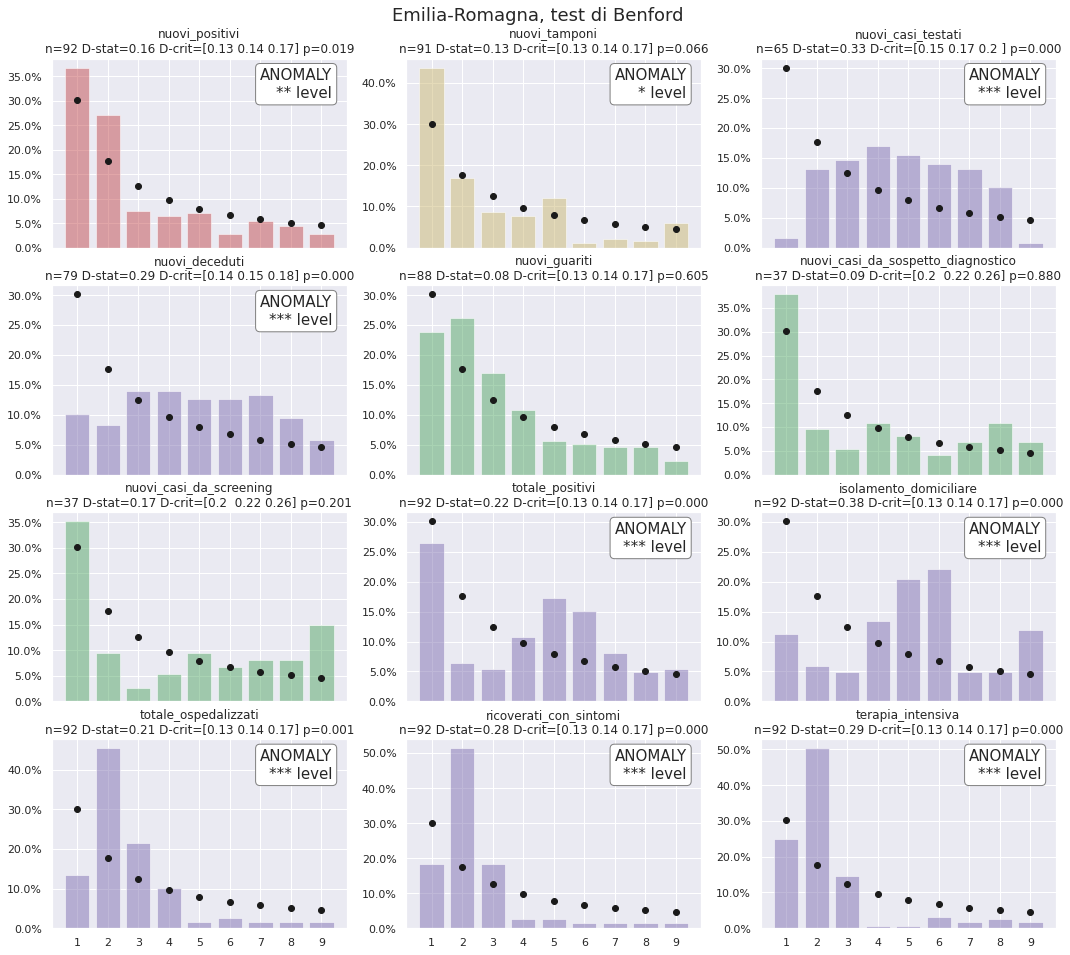

## Friuli Venezia Giulia

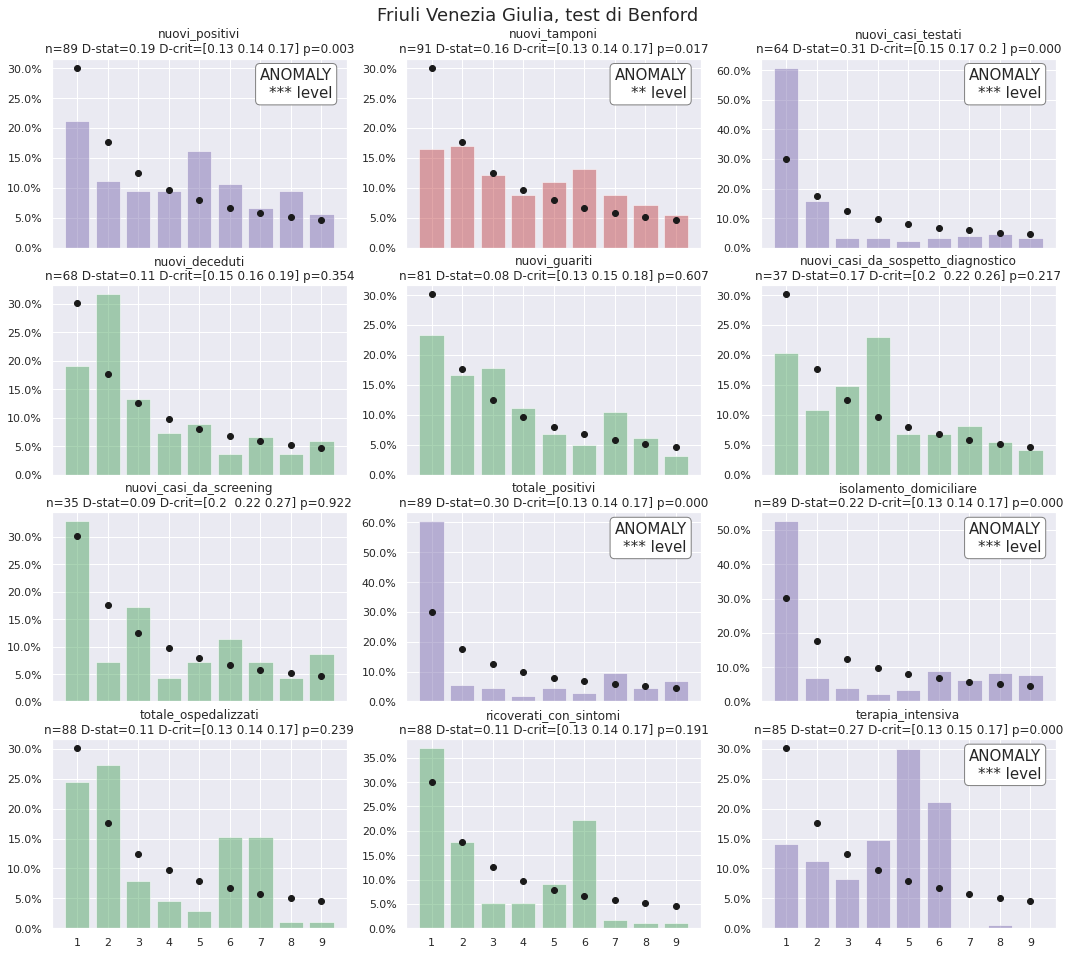

## Lazio

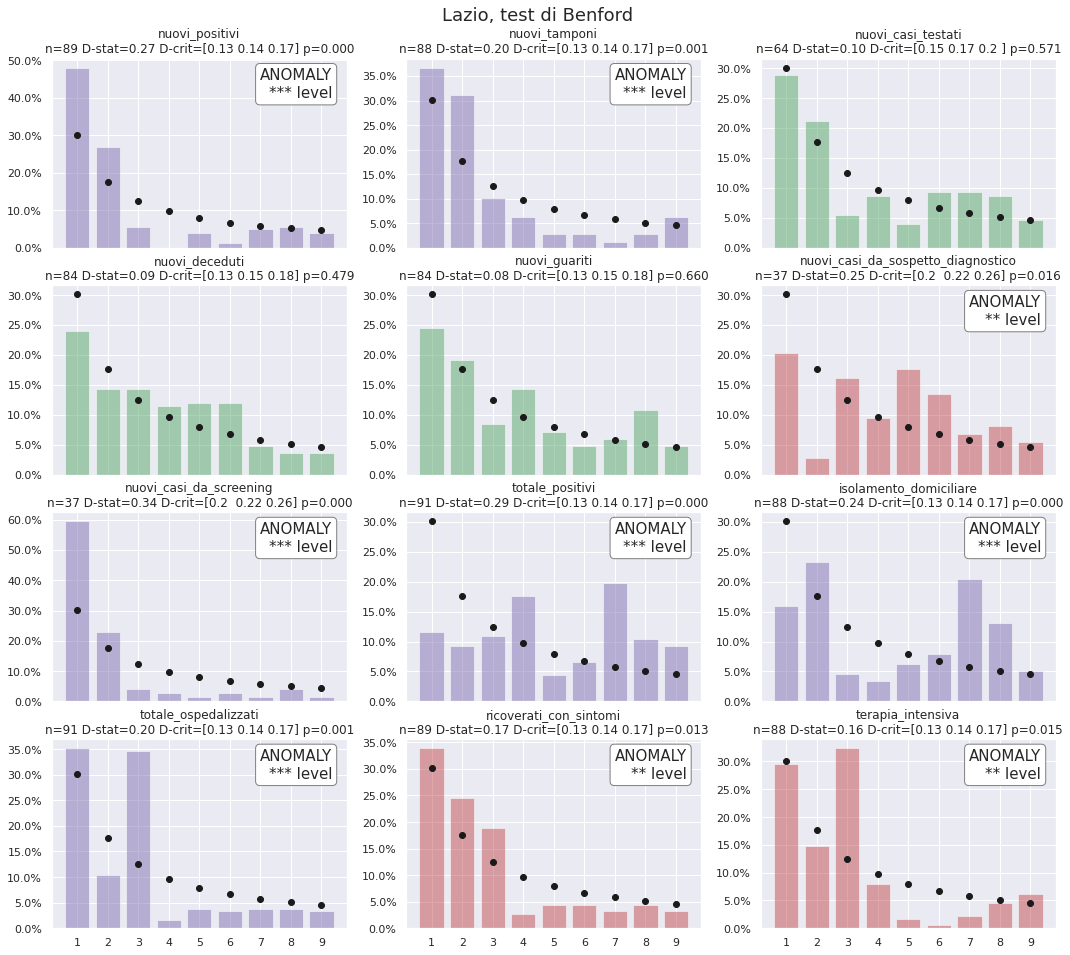

## Liguria

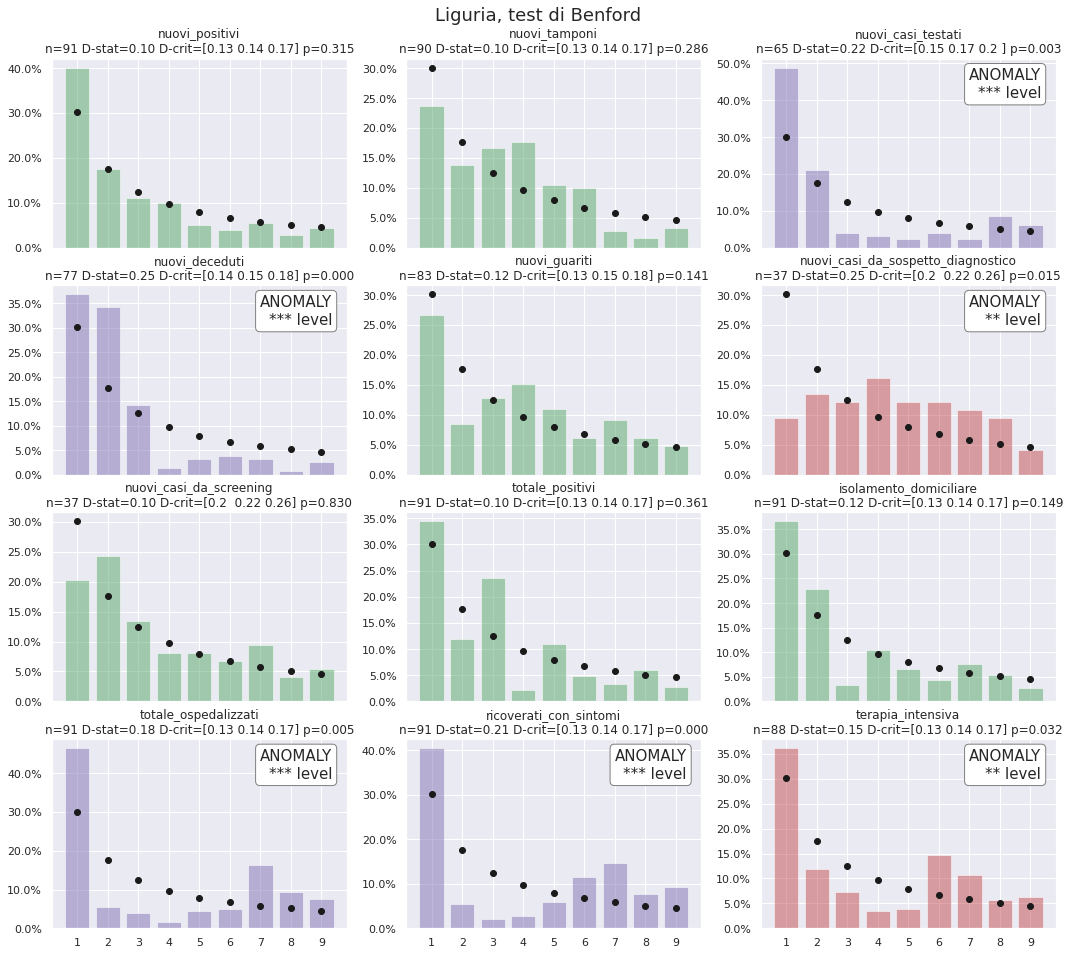

## Lombardia

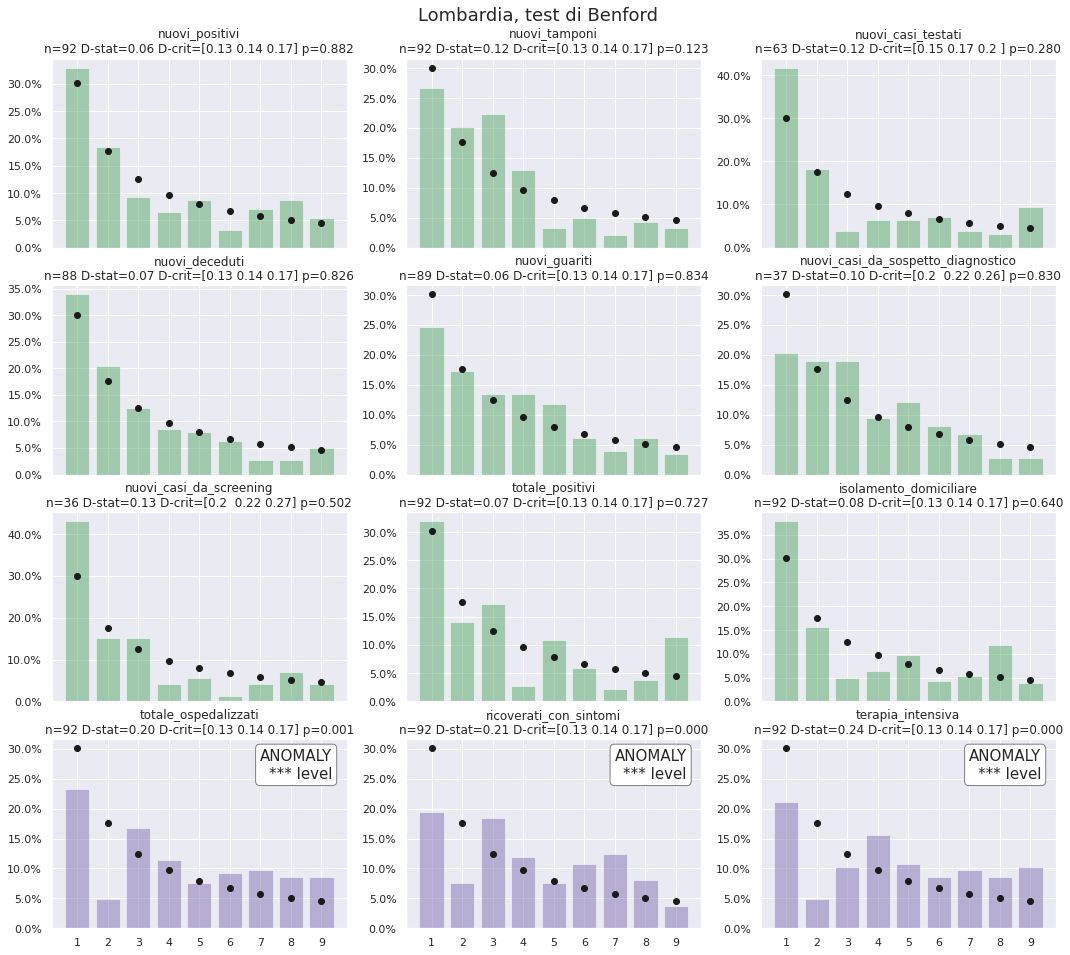

## Marche

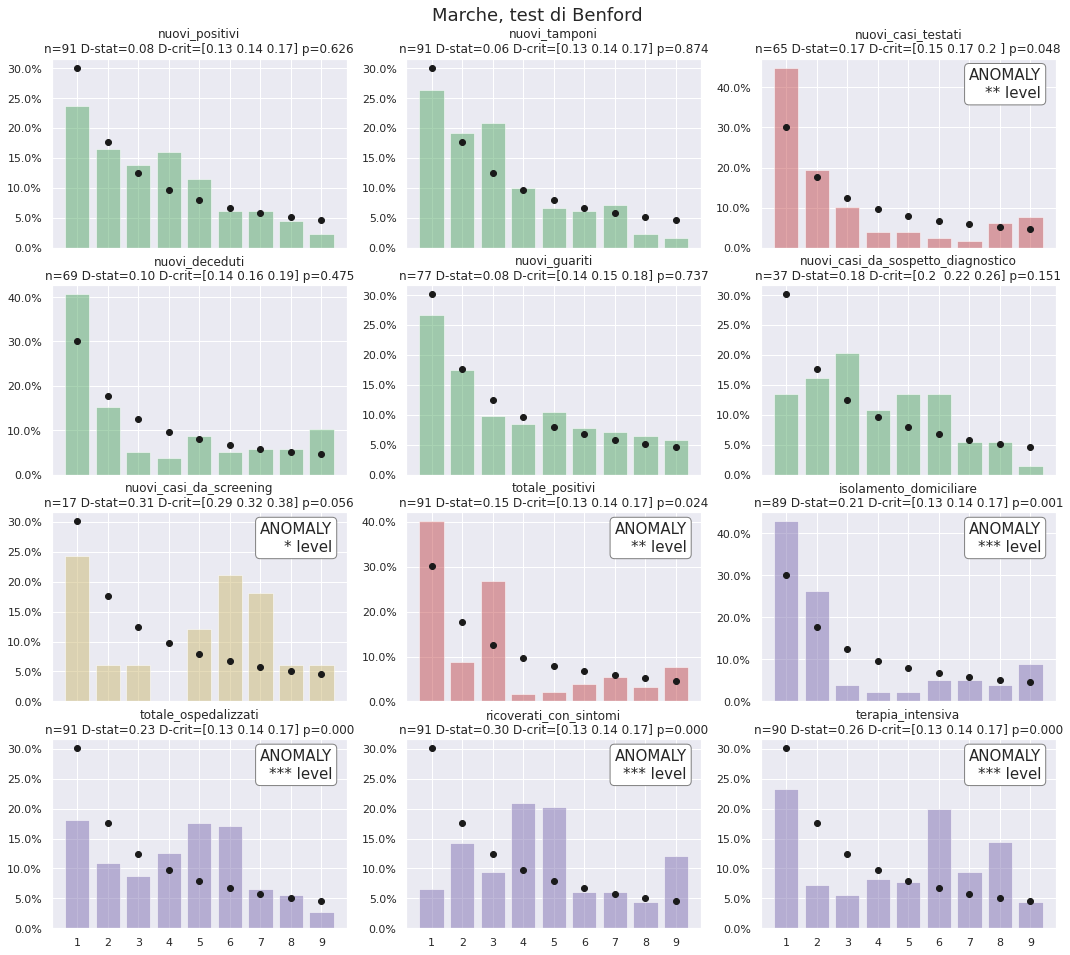

## Molise

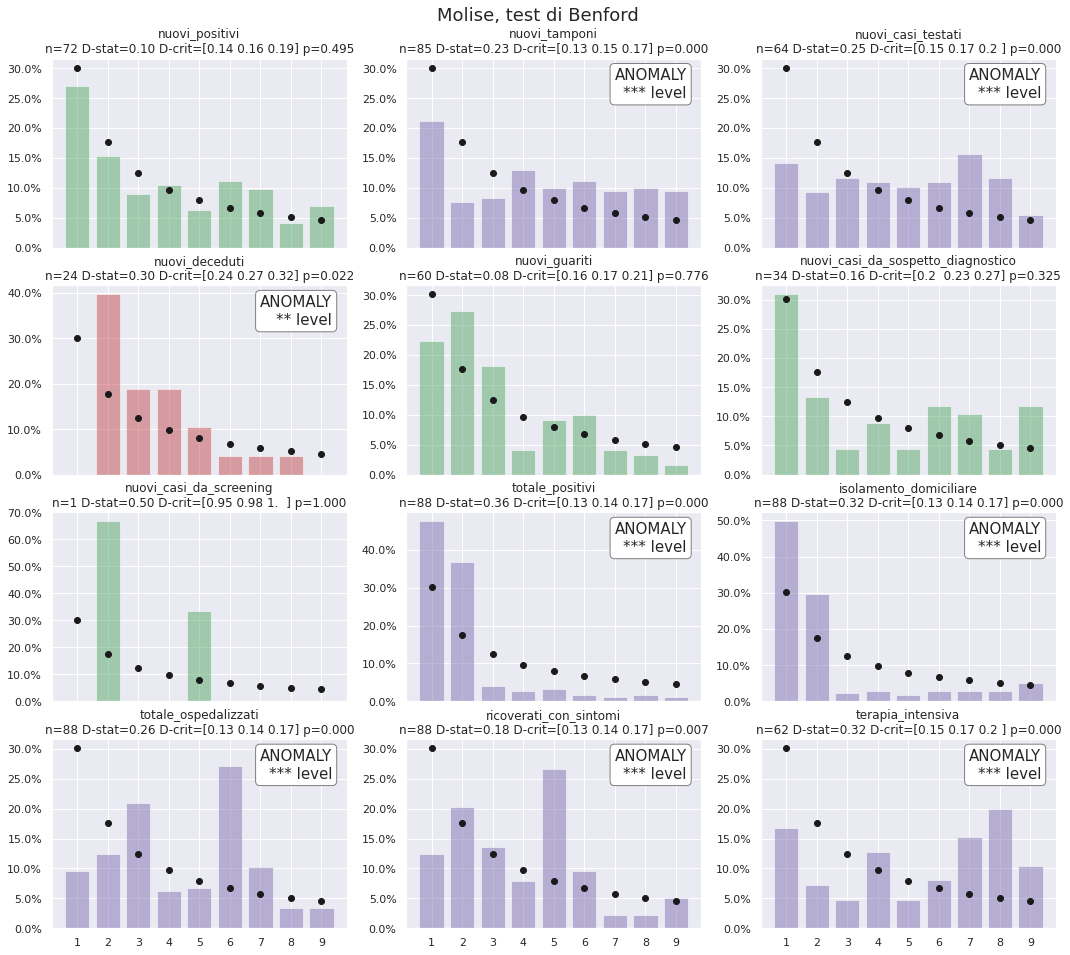

## P.A. Bolzano

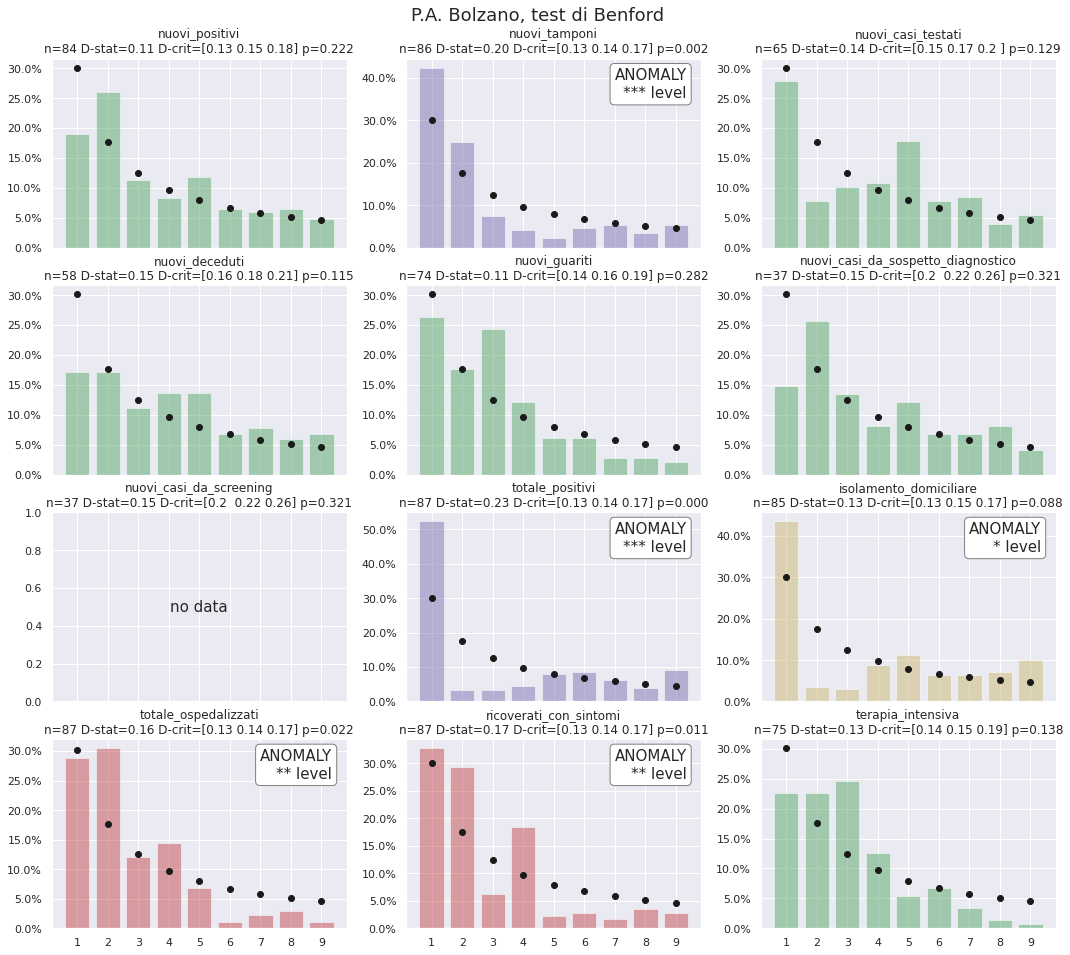

## P.A. Trento

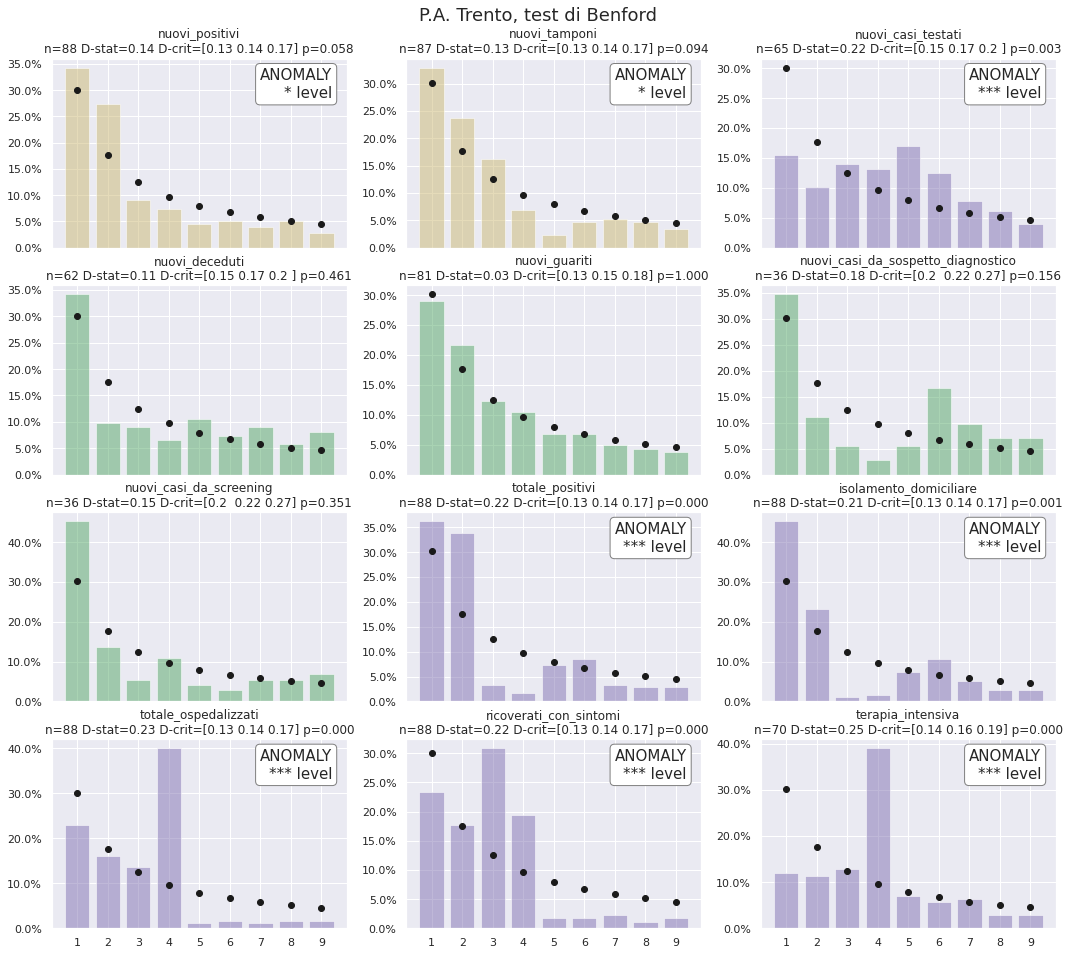

## Piemonte

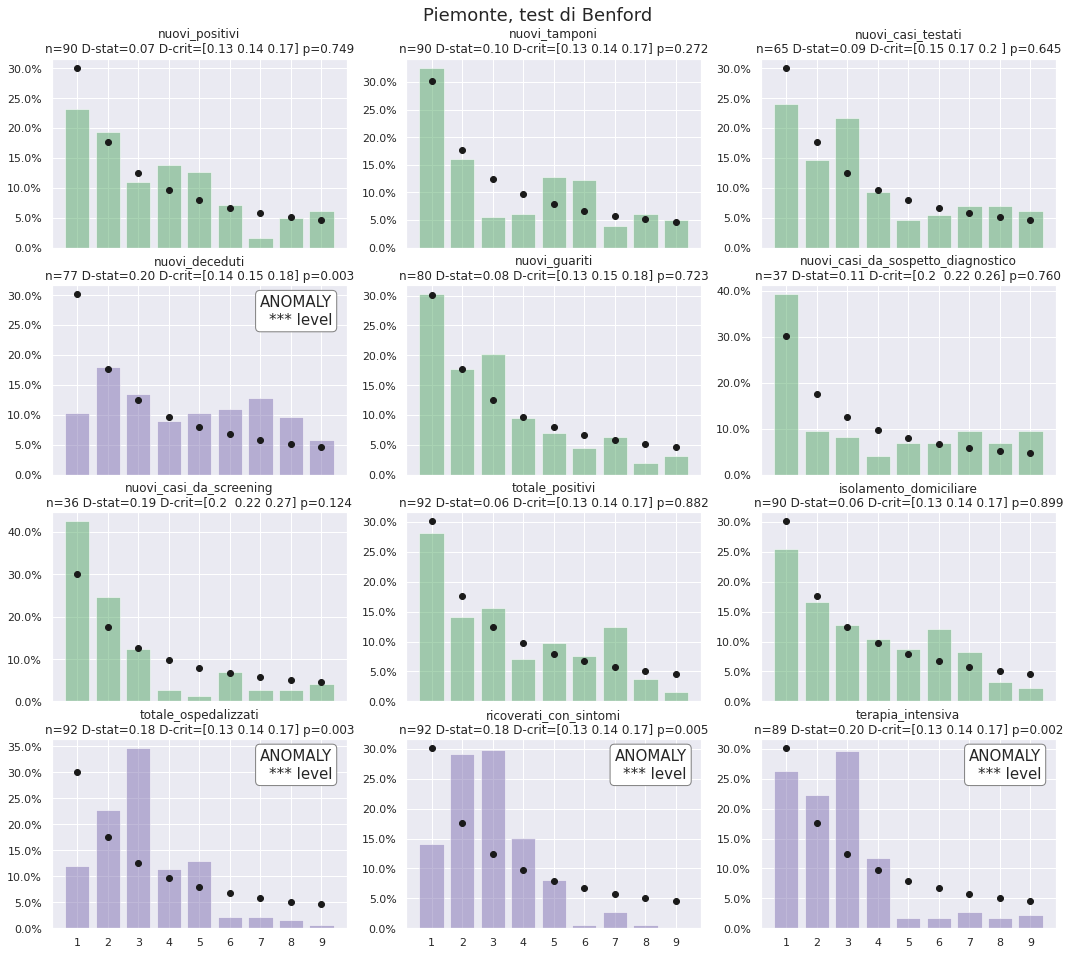

## Puglia

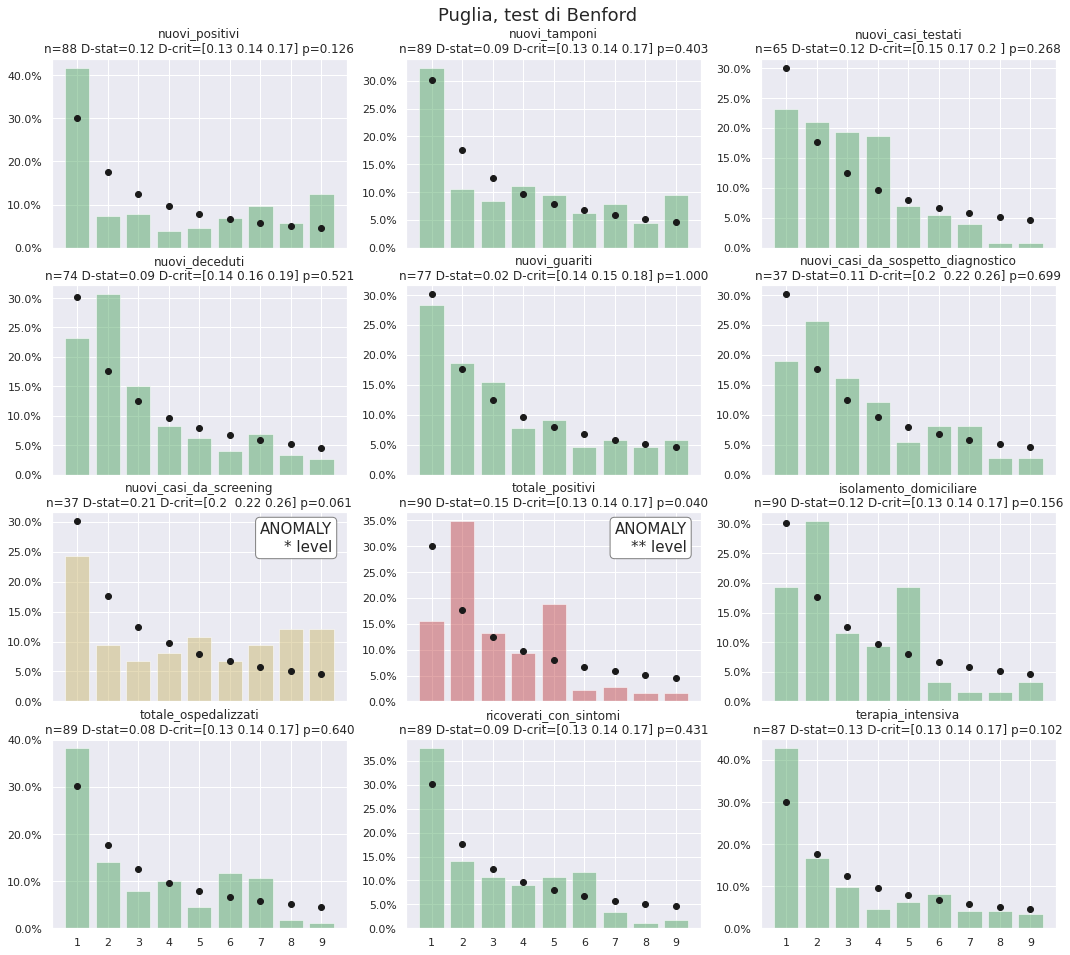

## Sardegna

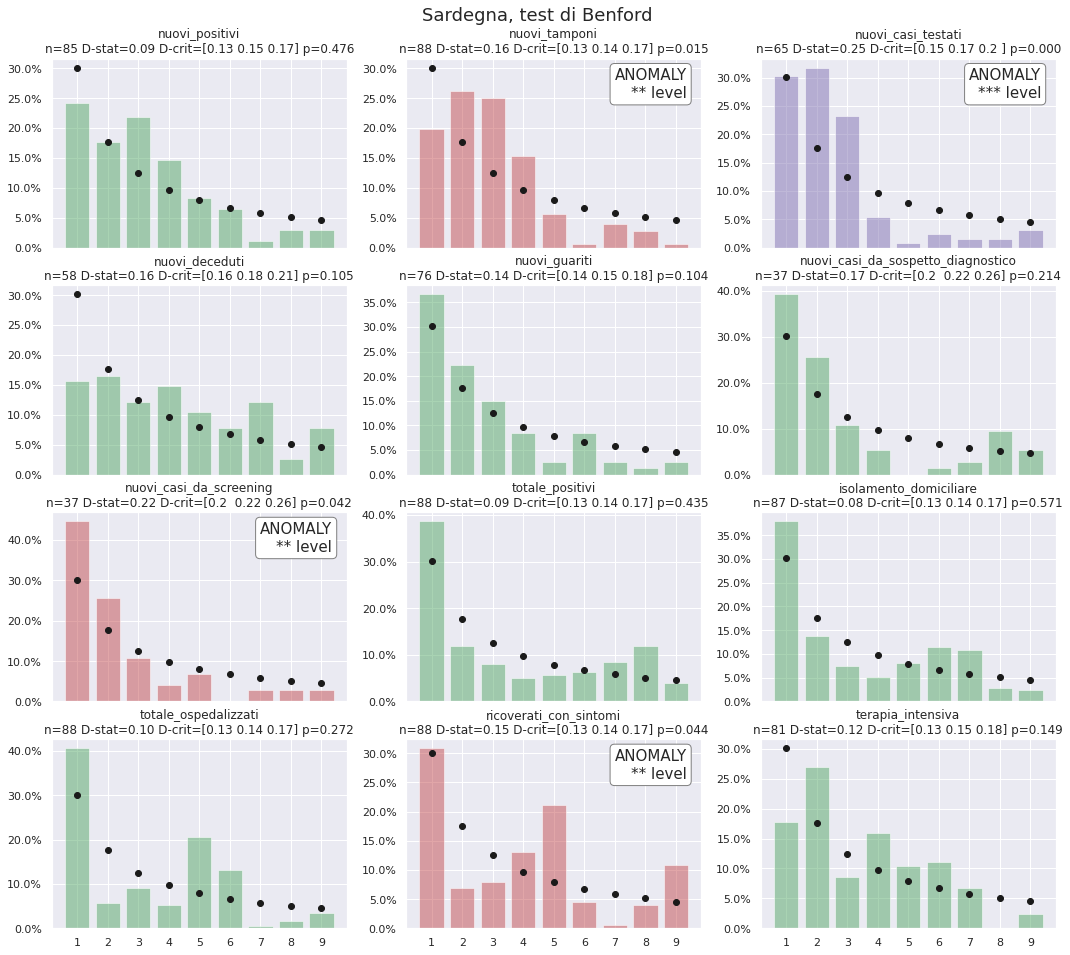

## Sicilia

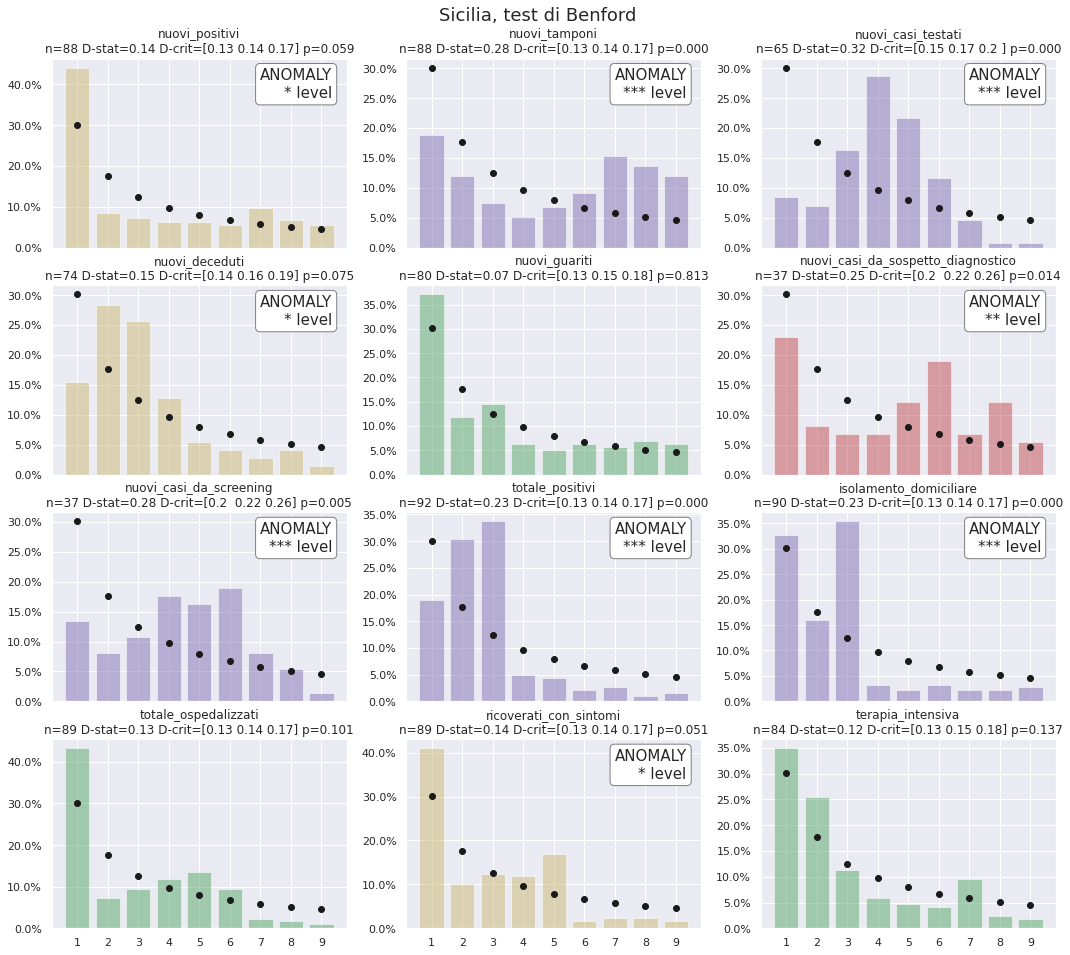

## Toscana

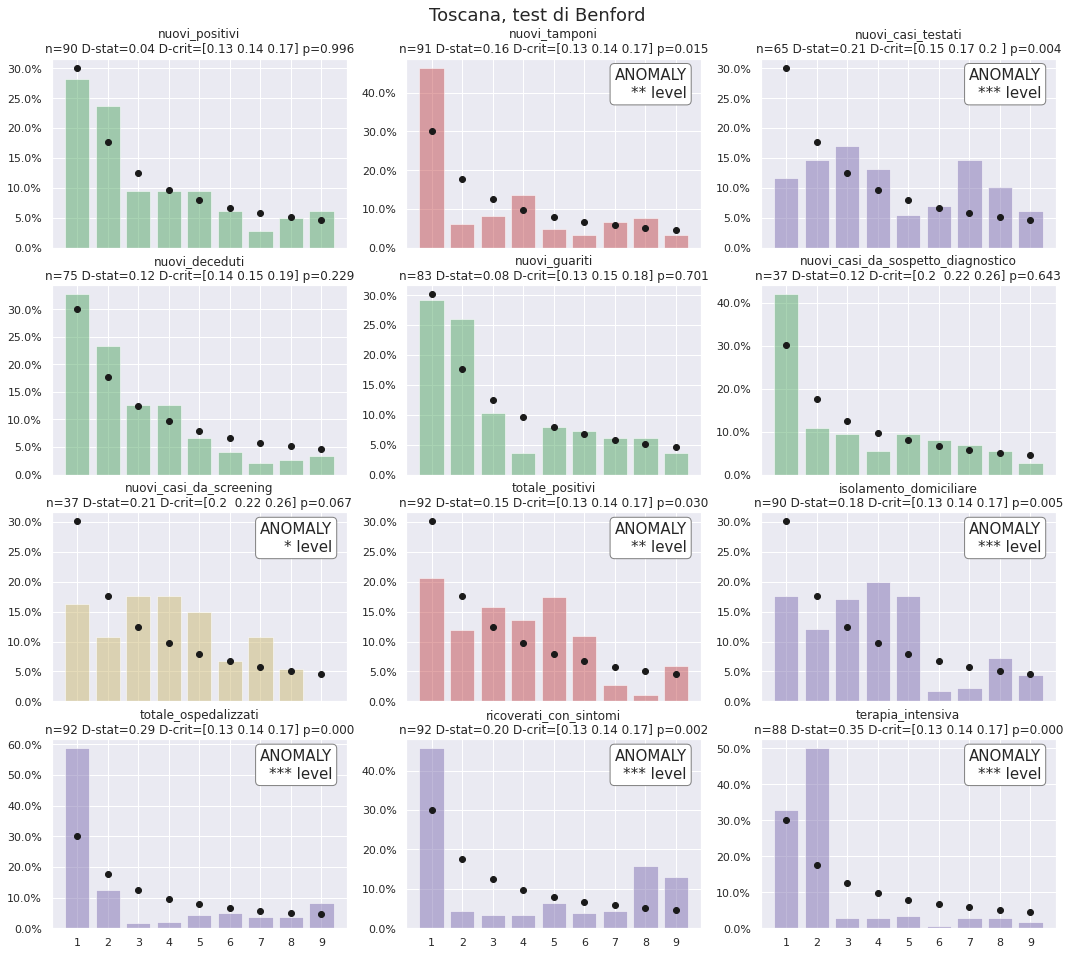

## Umbria

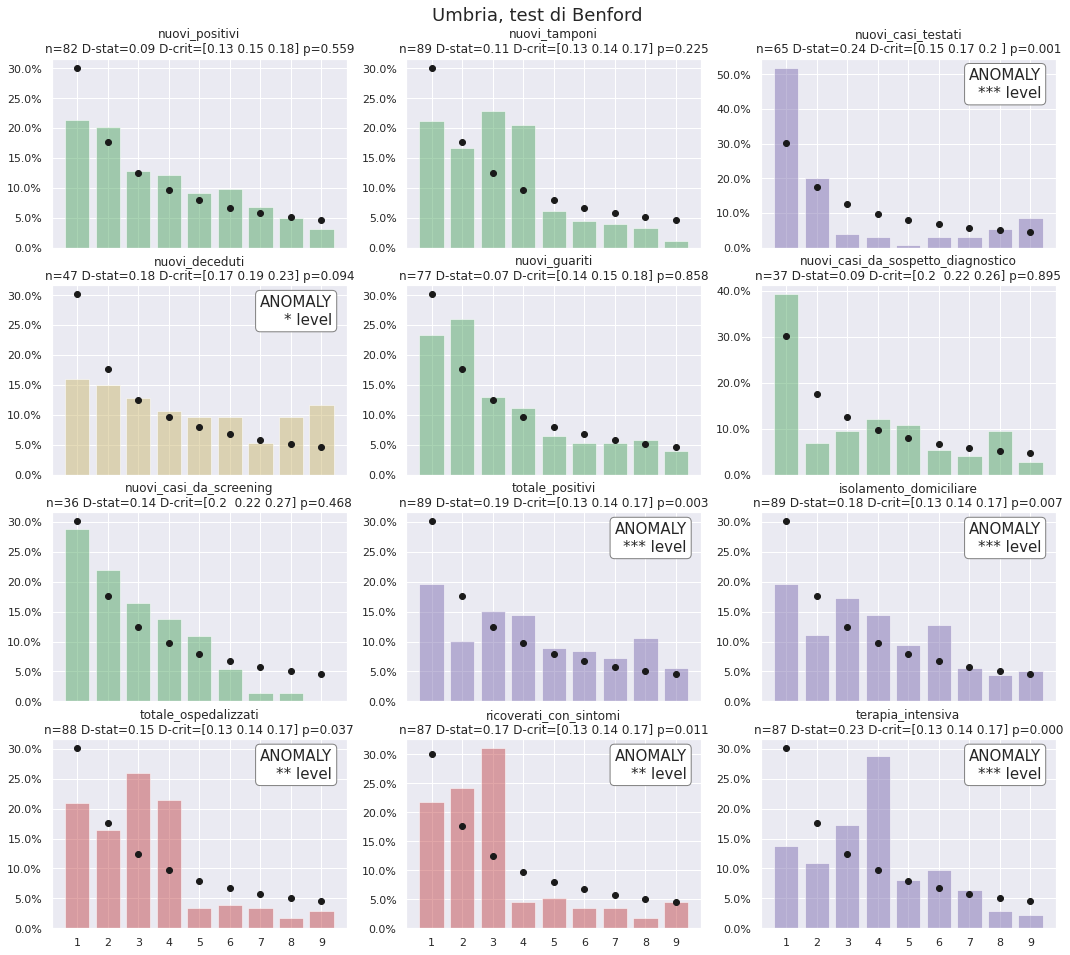

## Valle d'Aosta

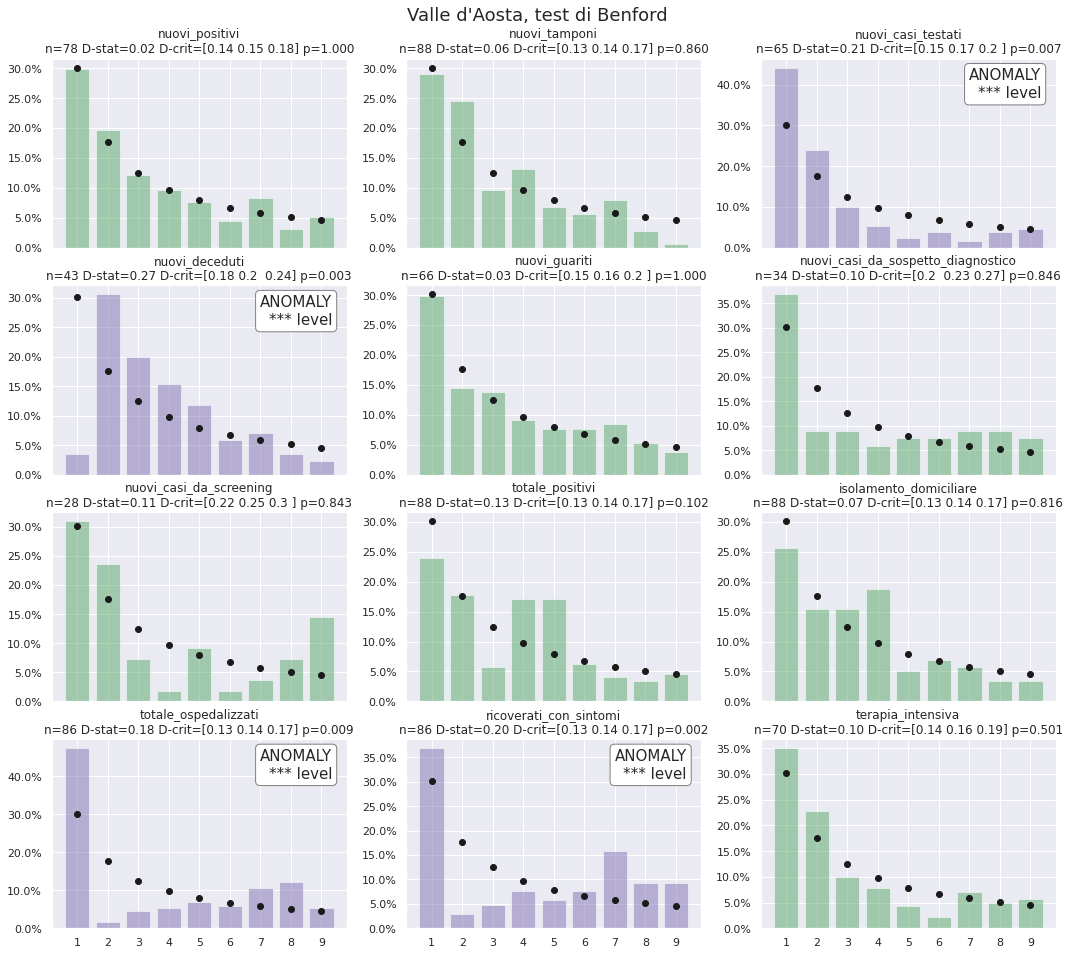

## Veneto

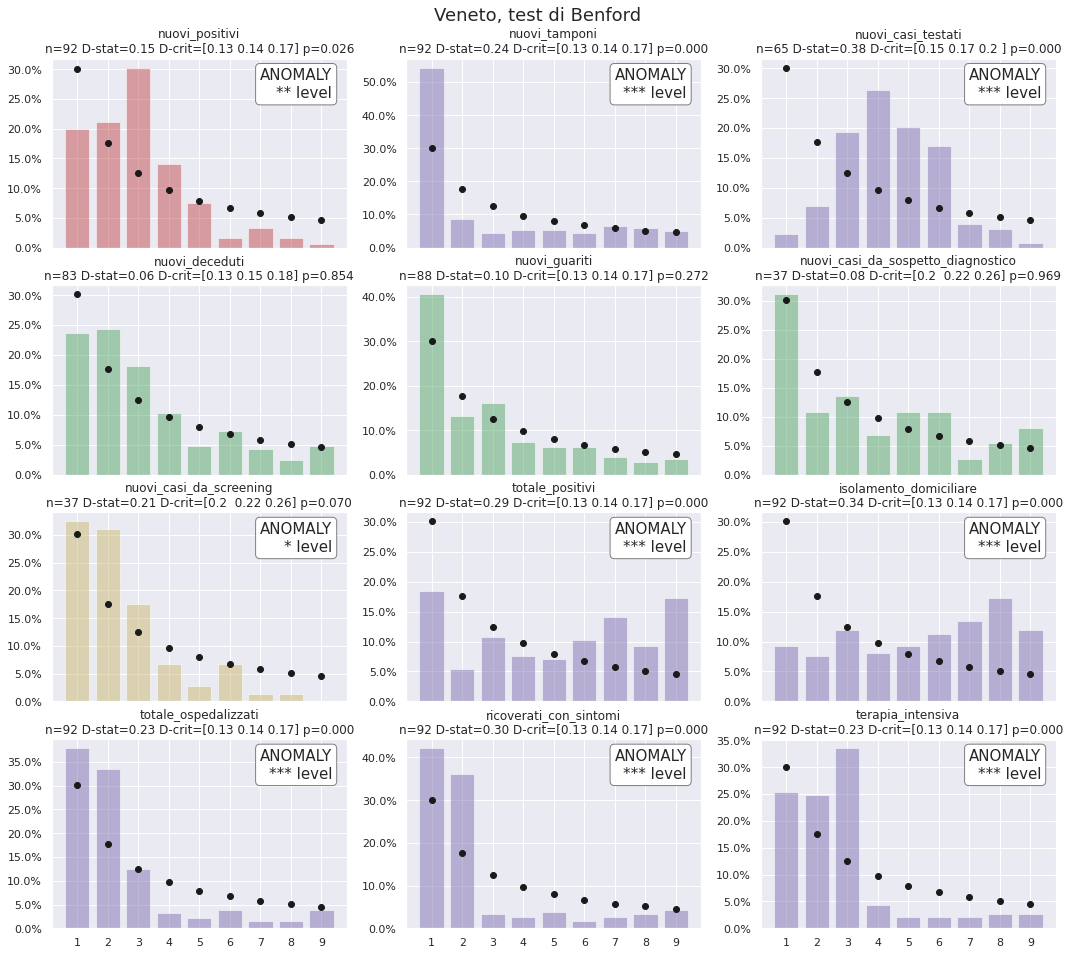

In [12]:
alphas = [.1, .05, .01]

results = {'regione': [], 'campo': [], 'p-val': [], 'livello': [], 'significatività': []}

for regione in sorted(it.denominazione_regione.unique()):

    df = it[it.denominazione_regione==regione].copy(deep=True)

    df.drop('stato', axis=1, inplace=True)
    df.drop('note', axis=1, inplace=True)

    #bl = benfordslaw(alpha=.05, method=None)

    df['nuovi_deceduti'] = df.deceduti.diff()

    df['nuovi_guariti'] = df.dimessi_guariti.diff()

    df['nuovi_casi_da_sospetto_diagnostico'] = df.casi_da_sospetto_diagnostico.diff()

    df['nuovi_casi_da_screening'] = df.casi_da_screening.diff()

    df['nuovi_tamponi'] = df.tamponi.diff()

    df['nuovi_casi_testati'] = df.casi_testati.diff()

    df['differenza_ricoverati'] = df.ricoverati_con_sintomi.diff()

    df['differenza_intensive'] = df.terapia_intensiva.diff()

    df['differenza_ospedalizzati'] = df.totale_ospedalizzati.diff()

    df['differenza_isolamenti'] = df.isolamento_domiciliare.diff()
    

    display(Markdown(f"## {regione}"))
    
    fig, ax = plt.subplots(4, 3, figsize=(3*6, 4*4), sharex=True)
    
    for i, col in enumerate(cols):
        Praw = np.nan
        X1 = df[wave_1_a:wave_1_z][col].dropna().values
        X2 = df[wave_2_a:wave_2_z][col].dropna().values
        X = np.concatenate((X1, X2))
        X = np.abs(X)
        X = X[X>1]
        if not X.size:
            ax.flat[i].text(
                .5, .5, 'no data',
                transform=ax.flat[i].transAxes,
                ha='center', va='center', fontsize=15
            )
        else:
            
            # Make distribution first digits
            counts_emp, percentage_emp, total_count, digit = _count_first_digit(X)
            # Expected counts
            counts_exp = _get_expected_counts(P, total_count)

            #assert np.sum(percentage_emp) == 1

            #stats1, Praw1 = sps.chisquare(percentage_emp*100, f_exp=P*100)
            #t, Praw_i = ast.kuiper(
            #    counts_emp, P.cumsum()
            #)
            #Praw = np.real(Praw_i)
            #stat, crit, Praw1 = sps.anderson_ksamp([counts_emp, counts_exp])
            #print(P)
            #print(Praw, col)
            #tstats2, Praw2 = sps.ks_2samp(percentage_emp*100, P*100)
            #tstats, Praw = sps.combine_pvalues([Praw1, Praw2], method='stouffer')
            #stat, crit, Praw = sps.anderson_ksamp([counts_emp, counts_exp])
            
            D_stat, D_crits, N, lev, sig, p_val = ks_test_two(counts_emp, counts_exp, alphas)
            #D_stat, D_crits, lev, sig = ks_test_two(percentage_emp*100, P*100, alphas)

            anomaly = False
            if lev == 0:
                color = 'g'
            if lev == 1:
                color = 'y'
                anomaly = True
            if lev == 2:
                color = 'r'
                anomaly = True
            if lev == 3:
                color = 'm'
                anomaly = True
            ax.flat[i].bar(digit, percentage_emp, alpha=.5, color=color)
            ax.flat[i].scatter(digit, P, color='k', zorder=3)
            if anomaly:
                ax.flat[i].text(
                    .95, .95,
                    f'ANOMALY\n{sig} level',
                    ha='right', va='top',
                    bbox=dict(boxstyle="round",
                           ec=(.5, .5, .5),
                           fc=(1., 1., 1.),
                           ),
                    fontsize=15,
                    transform=ax.flat[i].transAxes
                )
            ax.flat[i].yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
            
        ax.flat[i].set(
            xticks=digit,
            title=f"{col}\nn={int(np.round(N))} D-stat={D_stat:.2f} D-crit={np.round(D_crits, 2)} p={p_val:.3f}"
        )
        
        results['regione'].append(regione)
        results['campo'].append(col)
        results['p-val'].append(p_val)
        results['livello'].append(lev)
        results['significatività'].append(sig)
            
    fig.suptitle(f'{regione}, test di Benford', y=.925, fontsize=18)
    plt.show()
    
    _ = """
    # seconda ondata
    fig, ax = plt.subplots(4, 3, figsize=(3*6, 4*4), sharex=True)
    
    for i, col in enumerate(cols):
        Praw = np.nan
        X = df[wave_2_a:wave_2_z][col].dropna().values
        X = np.abs(X)
        if not X.size:
            ax.flat[i].text(
                .5, .5, 'no data',
                transform=ax.flat[i].transAxes,
                ha='center', va='center', fontsize=15
            )
        else:
            
            # Make distribution first digits
            counts_emp, percentage_emp, total_count, digit = _count_first_digit(X)
            # Expected counts
            counts_exp = _get_expected_counts(P, total_count)

            #assert np.sum(percentage_emp) == 1

            stats1, Praw1 = sps.chisquare(counts_emp, f_exp=counts_exp)
            tstats2, Praw2 = sps.ks_2samp(counts_emp, counts_exp)
            tstats, Praw = sps.combine_pvalues([Praw1, Praw2], method='fisher')

            if Praw > .1:
                color = 'g'
            elif Praw > .05:
                color = 'y'
            elif Praw > .01:
                color = 'r'
            elif np.isnan(Praw):
                color = 'w'
            else:
                color = 'm'
            ax.flat[i].bar(digit, percentage_emp, alpha=.5, color=color)
            ax.flat[i].scatter(digit, P, color='k', zorder=3)
            ax.flat[i].yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
            
        ax.flat[i].set(
            xticks=digit,
            title=f"{col}\n$p$-value: {Praw:.6f}"
        )
            
    fig.suptitle(f'{regione}, seconda ondata, test di Benford', y=.925, fontsize=18)
    plt.show()"""

# Sommario

In [13]:
res_df = pd.DataFrame(results)

In [14]:
res_df['1 - p-val'] = 1- res_df['p-val']

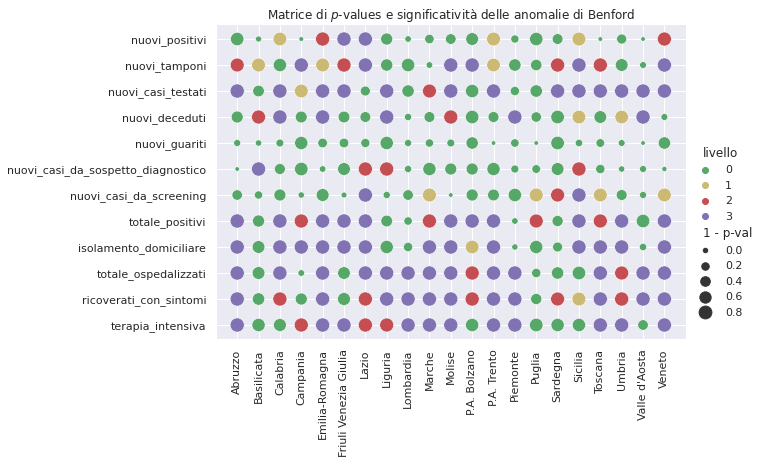

In [15]:
g = sns.relplot(
    data=res_df, kind='scatter',
    y='campo', x='regione',
    hue='livello',
    size='1 - p-val',
    sizes=(20, 200),
    palette=['g', 'y', 'r', 'm'],
    aspect=2,
)
g.axes.flat[0].tick_params(axis='x', labelrotation=90) 
g.axes.flat[0].set(
    title='Matrice di $p$-values e significatività delle anomalie di Benford',
    xlabel=None, ylabel=None
)
plt.show()

In [16]:
_ = """ax = res_df[res_df.regione=='Lombardia'].sort_values(by='p-val').plot(y='p-val', x='campo', marker='o')
ax.set_yscale('log')
for p in [.1, .05, .01]:
    ax.axhline(
        p, color='k', ls='--'
    )"""

In [17]:
_ = """reg_level = pd.DataFrame(
    res_df.groupby('regione')['p-val'].median()
).sort_values(by='p-val')"""

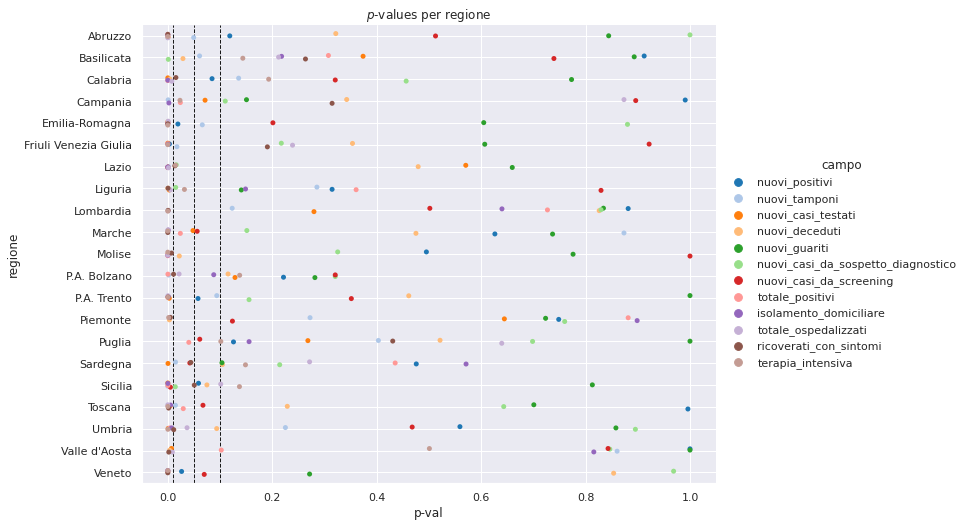

In [18]:
g = sns.catplot(
    data=res_df, kind='strip',
    hue='campo', palette='tab20',
    y='regione', x='p-val',
    aspect=1.5, height=7
)
for alpha in alphas:
    g.axes.flat[0].axvline(alpha, color='k', ls='--', lw=1)
g.axes.flat[0].grid(axis='y', color='w')
g.axes.flat[0].set(
    title='$p$-values per regione'
)
plt.show()

In [19]:
reg_level = pd.DataFrame(columns=['livello'], index=res_df.regione.unique())

for regione in reg_level.index:
    _df = res_df[res_df.regione==regione]
    significance = _df.livello.sum() / (_df.campo.unique().size * 3)
    reg_level.loc[regione, 'livello'] = significance

reg_level.sort_values(by='livello', ascending=False, inplace=True)

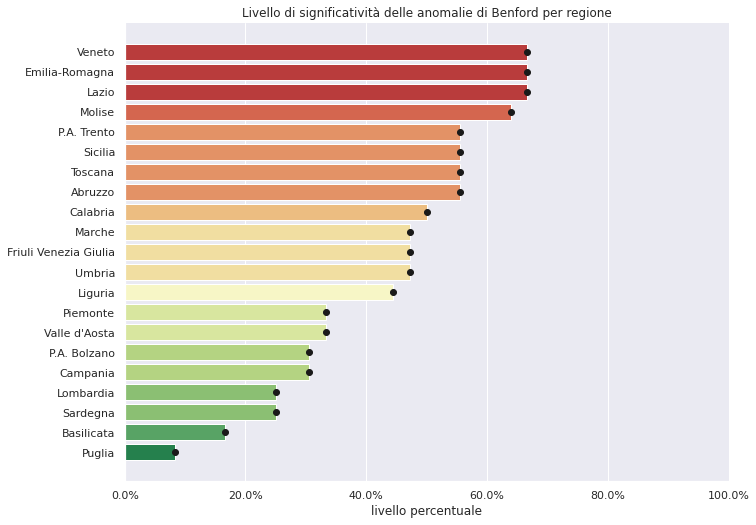

In [20]:
g = sns.catplot(
    data=reg_level, kind='bar',
    y=reg_level.index, x='livello',
    hue='livello', dodge=False,
    #palette=['g', 'y', 'r', 'm'],
    #facet_kws=dict(xlim=(0, 1)),
    palette='RdYlGn_r',
    aspect=1.5, height=7
)
g.axes.flat[0].scatter(
    reg_level.livello, reg_level.index,
    color='k', zorder=100
)
g.axes.flat[0].set(
    xlabel='livello percentuale', ylabel=None,
    xlim=(0, 1),
    #xscale='log',
    #xticks=[.01, .05, .1,],
    title='Livello di significatività delle anomalie di Benford per regione'
)
g.axes.flat[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
plt.show()

In [21]:
_ = """cam_level = pd.DataFrame(
    res_df.groupby('campo')['p-val'].mean()
).sort_values(by='p-val')

for campo in cam_level.index:
    _p_val = cam_level.loc[campo, 'p-val']
    significance = 0
    for p_val in [.1, .05, .01]:
        significance += 1 if _p_val < p_val else 0
    cam_level.loc[campo, 'significatività'] = significance

res_df"""

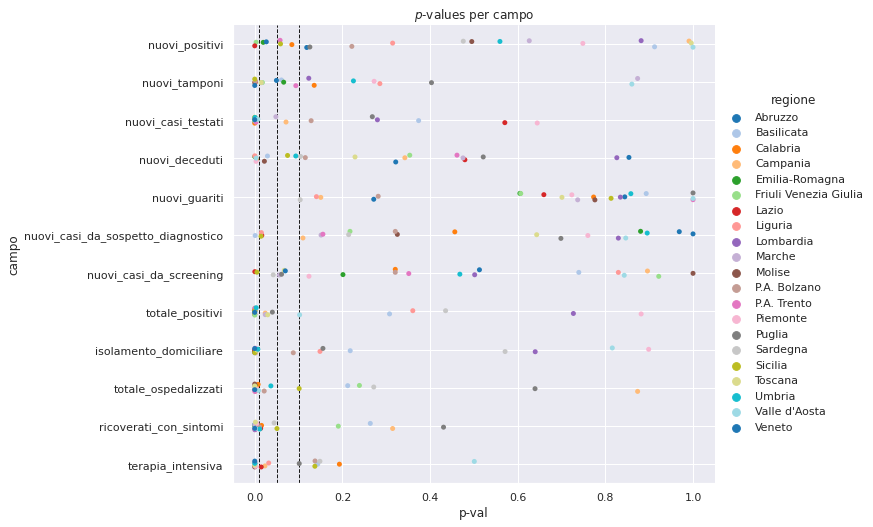

In [22]:
g = sns.catplot(
    data=res_df, kind='strip',
    hue='regione', palette='tab20',
    y='campo', x='p-val',
    aspect=1.5, height=7
)
for alpha in alphas:
    g.axes.flat[0].axvline(alpha, color='k', ls='--', lw=1)
g.axes.flat[0].grid(axis='y', color='w')
g.axes.flat[0].set(
    title='$p$-values per campo'
)
plt.show()

In [23]:
cam_level = pd.DataFrame(columns=['livello'], index=res_df.campo.unique())

for campo in cam_level.index:
    _df = res_df[res_df.campo==campo]
    significance = _df.livello.sum() / (_df.regione.size * 3)
    cam_level.loc[campo, 'livello'] = significance

cam_level.sort_values(by='livello', ascending=False, inplace=True)

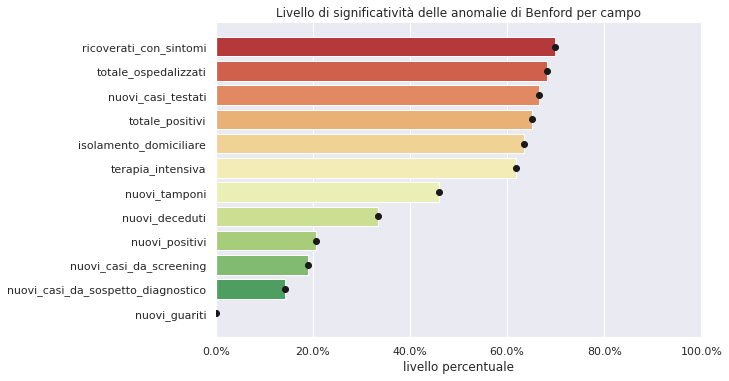

In [24]:
g = sns.catplot(
    data=cam_level, kind='bar',
    y=cam_level.index, x='livello',
    hue='livello', dodge=False,
    #palette=['g', 'y', 'r', 'm'],
    #facet_kws=dict(xlim=(0, 1)),
    palette='RdYlGn_r',
    aspect=2, height=5
)
g.axes.flat[0].scatter(
    cam_level.livello, cam_level.index,
    color='k', zorder=100
)
g.axes.flat[0].set(
    xlabel='livello percentuale', ylabel=None,
    xlim=(0, 1),
    #xscale='log',
    #xticks=[.01, .05, .1,],
    title='Livello di significatività delle anomalie di Benford per campo'
)
g.axes.flat[0].xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
plt.show()

In [25]:
_ = """import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table # EDIT: see deprecation warnings below

for region in res_df.regione.unique():
    _df = res_df[res_df.regione==region].drop('regione', axis=1)
    #_df = _df.pivot(index='index', columns=['ondata'], values=['significatività', 'P', 't'])
    fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis
    ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
    tabla = table(
        ax, _df, loc='upper right', 
        colWidths=[ .15, .15, .25, .25, .25, .25,]
    )  # where df is your data frame
    tabla.auto_set_font_size(False) # Activate set fontsize manually
    tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
    #tabla.scale(1.2, 1.2) # change size table
    ax.set(
        title=f'{region}'
    )
    plt.show()"""